## Demo of extracellular simulation of the Hay model with LFPy

Requirements:

- neuron (you should have it installed)
- LFP (`pip install LFPy`)
- neuroplotlib (`pip install git+https://github.com/alejoe91/neuroplotlib.git`)

In [1]:
import LFPy
import neuron
import os
import MEAutility as mu
import matplotlib.pylab as plt
import numpy as np
import neuroplotlib as nplt
%matplotlib notebook

This function loads the Hay model in LFPy. You can see it takes several parameters from NEURON and you can load morphologies alone or full models.

In [2]:
def load_hay_model(model_folder, dt, tstart, tstop):
    cwd = os.getcwd()
    os.chdir(model_folder)
    cell = None
    try:
        ##define cell parameters used as input to cell-class
        cellParameters = {
            'morphology': 'morphologies/cell1.asc',
            'templatefile': ['models/L5PCbiophys3.hoc',
                             'models/L5PCtemplate.hoc'],
            'templatename': 'L5PCtemplate',
            'templateargs': 'morphologies/cell1.asc',
            'passive': False,
            'nsegs_method': None,
            'dt': dt,
            'tstart': tstart,
            'tstop': tstop,
            'v_init': -80,
            'celsius': 34,
            'pt3d': True,
        }

        # Initialize cell instance, using the LFPy.Cell class
        neuron.load_mechanisms('mod')
        cell = LFPy.TemplateCell(**cellParameters)
    except:
        print('Failed to load Hay model. Wrong folder?')

    os.chdir(cwd)
    return cell

First, we load the cell and add a somatic current clamp with a current step:

In [3]:
hay_cell = load_hay_model('L5bPCmodelsEH/', dt=2**-5, tstart=0, tstop=200)
somatic_clamp = LFPy.StimIntElectrode(hay_cell, idx=0, pptype='IClamp', record_current=True, 
                                      amp=0.5, delay=10, dur=150)

<IPython.core.display.Javascript object>


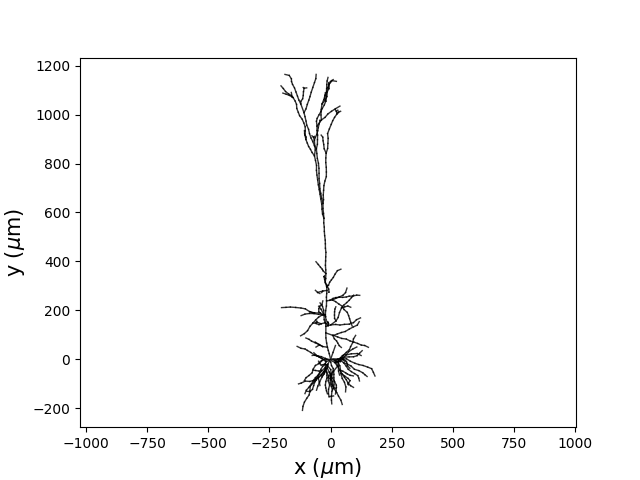

In [4]:
fig1 = plt.figure()
ax1 = fig1.add_subplot()
nplt.plot_neuron(hay_cell, plane='xy', ax=ax1)

In [5]:
hay_cell.simulate(rec_vmem=True, rec_imem=True)

We can probe the membrane potentials at the same locations as the Hay paper:

In [6]:
patch_y_locations = [0, 400, 620]

<IPython.core.display.Javascript object>


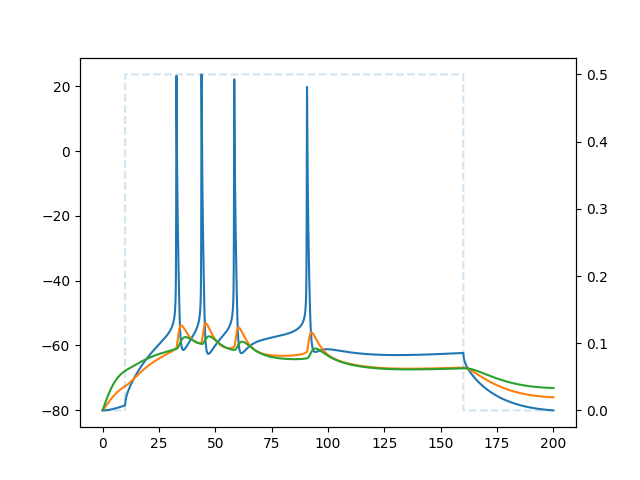

Y location: 0.0
Y location: 393.26333768541406
Y location: 626.9536221139831


In [7]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
for ploc in patch_y_locations:
    idx = hay_cell.get_closest_idx(y=ploc)
    print('Y location:', hay_cell.ymid[idx])
    ax2.plot(hay_cell.tvec, hay_cell.vmem[idx])
ax2b = ax2.twinx()
ax2b.plot(hay_cell.tvec, somatic_clamp.i, color='C0', ls='--', alpha=0.2)

## Extracellular probes

We can use the [MEAutility](https://meautility.readthedocs.io/en/latest/) package to quickly set up extracellular probes (or define new ones):

In [8]:
neuropixels = mu.return_mea('Neuropixels-128')

<IPython.core.display.Javascript object>


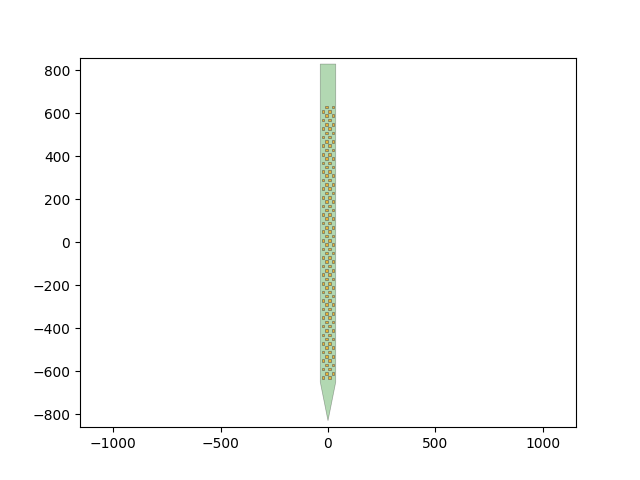

In [9]:
mu.plot_probe(neuropixels)

In [10]:
sq_mea = mu.return_mea('SqMEA-10-15')

<IPython.core.display.Javascript object>


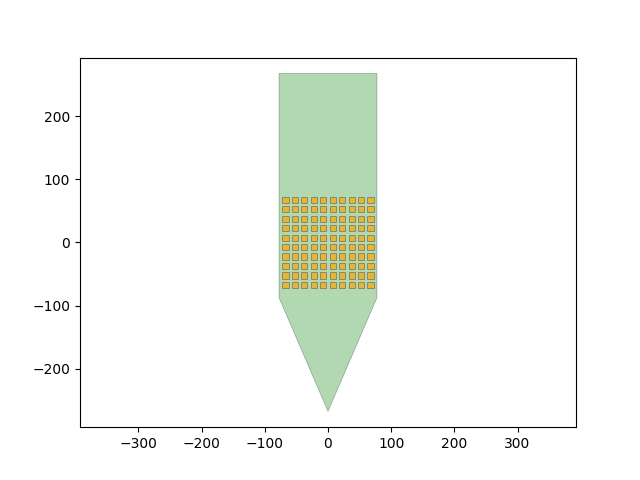

In [11]:
mu.plot_probe(sq_mea)

Let's use this square MEA (10x10, 15 um pitch). By default, the probe is on the yz plane, so we need to rotate it and move it to 'face' the neuron.

In [12]:
sq_mea.rotate([0, 1, 0], 90)

In [13]:
sq_mea.move([0, 0, -50])

<IPython.core.display.Javascript object>


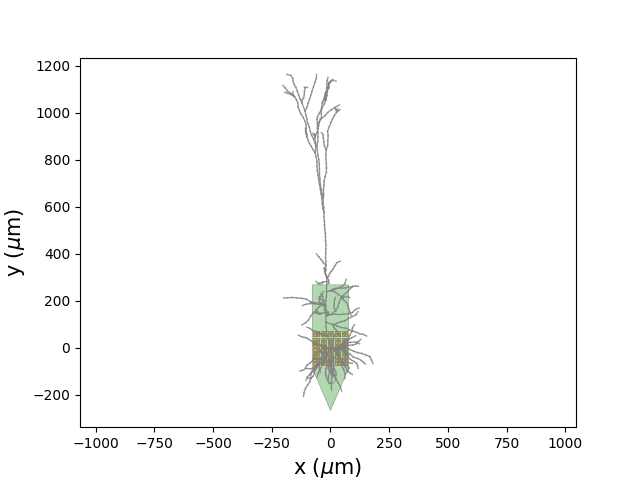

(-221.75170364379883,
 200.62629165649415,
 -339.07667236328126,
 1235.6101196289062)

In [16]:
fig3 = plt.figure()
ax3 = fig3.add_subplot()
mu.plot_probe(sq_mea, ax=ax3)
nplt.plot_neuron(hay_cell, plane='xy', ax=ax3)
ax3.axis('equal')

Since we already simulated the cell, we need to re-instantiate it:

In [17]:
hay_cell = load_hay_model('L5bPCmodelsEH/', dt=2**-5, tstart=0, tstop=200)
somatic_clamp = LFPy.StimIntElectrode(hay_cell, idx=0, pptype='IClamp', record_current=True, 
                                      amp=0.5, delay=10, dur=150)

Mechanisms already loaded from path: mod.  Aborting.
Overwriting custom temperature of 34.00. New temperature is 34.00


Now we create an `LFPy.RecExtElectrode` using the `sq_mea` object:

In [18]:
probe = LFPy.RecExtElectrode(probe=sq_mea)

And we can simulate the cell with the electrodes:

In [19]:
hay_cell.simulate(electrode=probe, rec_vmem=True, rec_imem=True)

In [20]:
lfp = probe.LFP * 1000 # in uV

<IPython.core.display.Javascript object>


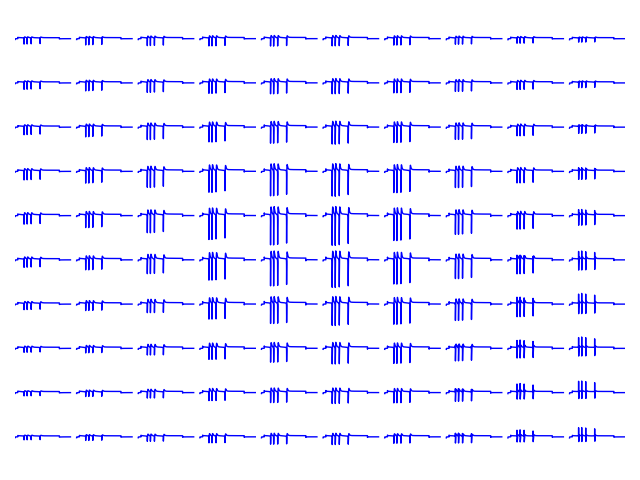

In [21]:
mu.plot_mea_recording(lfp, sq_mea, colors='b')